# Data analysis - Introduction for Gamma Spectroscopy

## Table of Content

* [About this Notebook](#about)


* [Read experimental data from file](#read)
    * [Plotting the data](#plot)


* [Fit of data](#fit)
    * [Fitting Gaussians](#gaussian)
    * [Fit a line](#line)


* [Statistical analysis](#stat)

## About this Notebook <a name="about"></a>

The purpose of this _jupyter_ notebook is to introduce data analysis in the frame of gamma spectroscopy. The example programming language is _Python3_, but of course most coding languages can do the job properly. If you have never programmed before there are so many great tutorials available across the web. There even exist plenty _Open Online Courses_, e.g. https://www.coursera.org/learn/python. Please have a look around for the one that you like the best. 

The data analysis can roughly be divided into four steps:
1. Read experimental data from file.
2. Fit Gaussians to peaks. 
3. Calibrate the detector response.
4. Perform a statistical analysis (e.g. error propagation) and present results.

A dedicated python library, located in `py_framework/`, have been implemented for the data analysis connected to the labs in FYSC12 Nuclear Physics. The framework comprises functions that support 1-3 of the above-mentioned steps.

Full Python3 coding examples of how to perform the different steps of the data analysis is given below. Every example is finished with a template of how the `py_framework/` can be used to perform the same calculations. 

**NOTE**: It is strongly recommended that you program your own functions instead of using the framework directly out of the book. As you will find out, there will come a point where the framework functionalities are not to your satisfaction, and then you need to code yourself. So, better get used to it right away. 

## Read experimental data from file <a name="read"></a>

The following code segment exemplifies how to read in an experimental data file into a list container. For an introduction on how to read and write files see e.g. http://www.pythonforbeginners.com/files/reading-and-writing-files-in-python.

In [1]:
array_of_data = list()
read_lines = 0
total_data = 0
start_read = False
with open("test_data.Spe") as file:
    for j, line in enumerate(file):
        #if j < 100:
            #print(line.split())
        if line.split()[0] == '$DATA:':
            #print(line.split())
            start_read = True
        elif start_read and read_lines == 0:
            #print(line.split())
            total_data = int(line.split()[1])+1
            #print(total_data)
            read_lines = read_lines + 1
            continue
        elif start_read and line.split()[0] != '$ROI:':
            #print(line.split())
            array_of_data.append(int(line.split()[0]))
        elif start_read:
            break
        
print("Should read:", total_data, "lines. And read:", len(array_of_data))
        

Should read: 8192 lines. And read: 8192


With the framework it is possible to perform conceptually the same operations through:

In [2]:
from py_framework.MCA import *
data = load_spectrum("test_data.Spe")

ImportError: No module named 'py_framework'

### Plotting the data <a name="plot"></a>

It is always good to visualise your data. This is how you can plot and visualise it in Python3.

In [4]:
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook

#The following line is the ONLY one needed in stand-alone applications!
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<IPython.core.display.Javascript object>


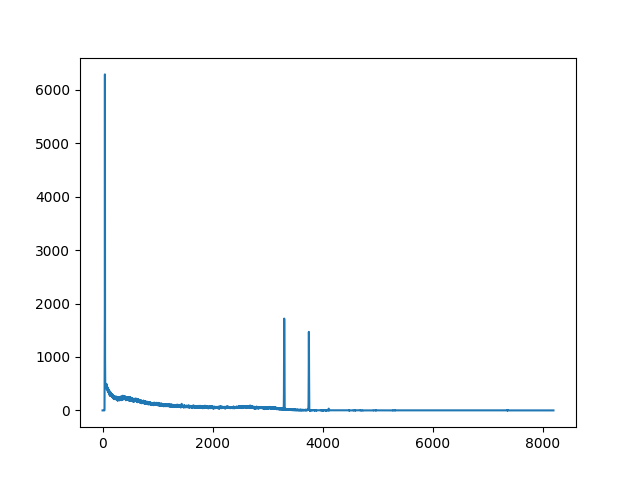

In [5]:
plt.figure()
plt.plot(array_of_data)
plt.savefig("test_spectrum.png")
#axis = plt.gca()
#axis.plot(array_of_data)

## Could be useful to see this in log scale..?
#plt.yscale('log')
#plt.ylim(ymin=1)

## Fit of data <a name="fit"></a>

Fitting functions can be made simply with the `scipy.optimize` module. The function `curve_fit` does the job for you and the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) contains all the valuable information on how to use the function. It uses a method called least squares which you can read about in most course literature on statistics and for instance on [Wolfram Alpha](http://mathworld.wolfram.com/LeastSquaresFitting.html). 

### Fitting Gaussian <a name="gaussian"></a>

The following code shows how to use the function `curve_fit` to fit a peak in the data that was read in above (i.e. you will need to execute the above code section before this section will work).


In [ ]:
from scipy.optimize import curve_fit

def GaussFunc(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#mu = np.asarray([3300, 3750])
#E = np.asarray([1173.2, 1332.5])
mu = 3300
A = array_of_data[mu]
sigma = 1
guess = [A, mu, sigma]
n = 50 #number of points on each side to include in fit

x = np.asarray(range(len(array_of_data)))
y = np.asarray(array_of_data)

estimates, covar_matrix = curve_fit(GaussFunc,
                                    x[mu-n:mu+n],
                                    y[mu-n:mu+n],
                                    p0=guess)

print("Estimates of (A mu sigma) = (", estimates[0], estimates[1], estimates[2], ")\n")

print("Covariance matrix = \n", covar_matrix, "\n")

print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", covar_matrix[0][0], covar_matrix[1][1], covar_matrix[2][2], "]" )

plt.figure()
plt.plot(x[mu-n:mu+n],y[mu-n:mu+n], linestyle="", marker="*")
plt.plot(x[mu-n:mu+n], GaussFunc(x[mu-n:mu+n], estimates[0], estimates[1], estimates[2]))


With the framework:

In [ ]:
from py_framework.fithelpers import *

gauss = fit_gaussian_at_idx(x, y, mu, npoints=n)
print("Estimates of (A mu sigma) = (", gauss.A, gauss.mu, gauss.sigma, ")\n")

print("Covariance matrix = \n", covar_matrix, "\n")

print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", covar_matrix[0][0], covar_matrix[1][1], covar_matrix[2][2], "]" )


### Fit a line <a name="line"></a>

In [ ]:
x = np.asarray([1,3,5,7])
y = np.asarray([1.3, 2.1, 2.9, 4.2])
#If you are more or less uncertain about your y-values this can be used in the fit by including the following line.
sigmay = np.asarray([0.5, 0.3, 0.1, 0.2])

guess = [2, 1]

def LineFunc(x, k, m):
    return k*x+m

estimates, covar_matrix = curve_fit(LineFunc,
                                    x,
                                    y,
                                    p0 = guess,
                                    sigma = sigmay)

print("Estimates of (k m) = (", estimates[0], estimates[1], ")\n")

#print("Covariance matrix = \n", covar_matrix, "\n")

#print("Uncertainties in the estimated parameters: \n[ sigma^2(A) sigma^2(mu), sigma^2(sigma) ] = \n[", covar_matrix[0][0], covar_matrix[1][1], covar_matrix[2][2], "]" )

plt.figure()
plt.plot(x,y, linestyle="", marker="*")
plt.plot(x, LineFunc(x, estimates[0], estimates[1]))


## Statistical analysis <a name="stat"></a>

Background theory and instructions on how to perform statistical analysis on experimental data, with error propagation, can be found e.g. [here](http://www.fysik.lu.se/fileadmin/fysikportalen/UDIF/Bilder/FYSA31_KF_error.pdf), but of course also easily through a google search.